In [1]:
import numpy as np
import os
import sys


In [2]:
sys.path.append('/home/caffe-user/caffe/python/')


In [3]:
import caffe


In [4]:
caffe.set_mode_gpu()


In [5]:
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
from scipy import signal

In [7]:
net = caffe.Net('/home/caffe-user/caffe/models/bvlc_reference_caffenet/deploy.prototxt', '/home/caffe-user/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', caffe.TEST)


In [8]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})


In [9]:
# This is from our current code which uses ILSVRC_2012 image set for training
# The PlacesNet image set is different
trans_model = np.load('/home/caffe-user/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy')


In [10]:
# the mean of any dataset composed of natural images should be close to [104, 117, 123].
# My guess for greyscale is 115 ... 
trans_model.mean(1).mean(1)



array([ 104.00698793,  116.66876762,  122.67891434])

In [11]:
transformer.set_transpose('data', (2, 0, 1))
# Values from BlobProto notebook from places205CNN_mean.binaryproto
transformer.set_mean('data', trans_model.mean(1).mean(1))
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2, 1, 0))


In [12]:
def myTestFiles():
    file_list = []
    with open('/downloads/kenglish/data/protest_concert/files.lst', 'r') as f:
        for line in f:
            fpath = line.rstrip()
            file_list.append(fpath)
    return file_list

In [13]:
# NOTE:  I had to delete corrupted files from the file list
files = myTestFiles()
net.blobs['data'].reshape(len(files), 3, 227, 227)
i = 0
for fpath in files:
    net.blobs['data'].data[i] = transformer.preprocess('data', caffe.io.load_image(fpath))
    i += 1


In [14]:
net.forward()

{'prob': array([[  2.96074109e-06,   1.05774234e-05,   1.10066867e-05, ...,
           1.86541479e-06,   9.31652976e-05,   1.10132733e-05],
        [  2.31958765e-07,   5.96108111e-06,   8.71833799e-06, ...,
           2.25066628e-06,   4.03781160e-05,   3.67437224e-06],
        [  1.48275910e-06,   1.07829874e-04,   4.29514557e-06, ...,
           1.02066115e-05,   3.94420727e-04,   5.48260141e-05],
        ..., 
        [  7.33461434e-08,   2.29140915e-06,   8.76468278e-07, ...,
           3.32213006e-07,   2.56489602e-05,   6.61659487e-06],
        [  9.34105415e-08,   5.09251151e-07,   6.98679372e-08, ...,
           4.79063829e-08,   5.71175178e-06,   7.25702932e-07],
        [  2.46839761e-07,   1.81030136e-05,   2.67839846e-06, ...,
           3.18771924e-07,   2.82288529e-04,   1.87977330e-05]], dtype=float32)}

In [15]:
net.blobs.keys()

['data',
 'conv1',
 'pool1',
 'norm1',
 'conv2',
 'pool2',
 'norm2',
 'conv3',
 'conv4',
 'conv5',
 'pool5',
 'fc6',
 'fc7',
 'fc8',
 'prob']

In [16]:
net.blobs['conv3'].data[0].shape

(384, 13, 13)

In [19]:
min(net.blobs['conv3'].data[0].flatten()) , max(net.blobs['conv3'].data[0].flatten())

(0.0, 275.66324)

In [22]:
np.dot(net.blobs['conv3'].data[0].flatten()/256.0,net.blobs['conv3'].data[1].flatten()/net.blobs['conv3'].data[0].shape[0])

183.08368

In [23]:
def dist(V, W, scale):
    D = (W.flatten() - V.flatten()) / scale
    return np.dot(D, D)/np.prod(V.shape)

In [40]:
tags = ["day_concert", "day_protest", "night_concert", "night_protest"]
def getTag(imageNum):
    tag = ""
    if imageNum < 51:
        tag = tags[0]
    elif imageNum < 100:
        tag = tags[1]
    elif imageNum < 150:
        tag = tags[2]
    else:
        tag = tags[3]
    return tag


In [26]:
imageId_by_tag = {}
for i in range(len(net.blobs['conv3'].data)):
    tag = getTag(i)
    if tag not in imageId_by_tag:
        imageId_by_tag[tag] = []
    imageId_by_tag[tag].append(i)
    
cluster_conv3_by_tag = {}
for tag in imageId_by_tag:
    cluster_conv3_by_tag[tag] = np.zeros(net.blobs['conv3'].data[0].shape)
    for id in imageId_by_tag[tag]:
        for feat_id in range(len(net.blobs['conv3'].data[id])):
            cluster_conv3_by_tag[tag][feat_id] += net.blobs['conv3'].data[id][feat_id]
        cluster_conv3_by_tag[tag][feat_id] *= (1.0/len(imageId_by_tag[tag]))

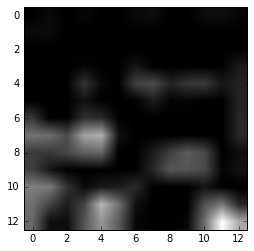

In [27]:
plt.imshow(net.blobs['conv3'].data[0][0], cmap = plt.get_cmap('gray'))

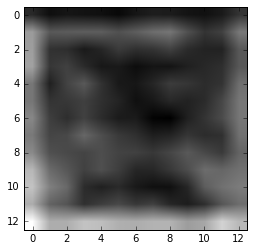

In [28]:
plt.imshow(cluster_conv3_by_tag['day_concert'][0], cmap = plt.get_cmap('gray'))

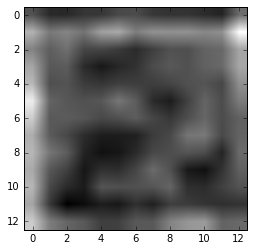

In [29]:
plt.imshow(cluster_conv3_by_tag['day_protest'][0], cmap = plt.get_cmap('gray'))

In [41]:
tag_feature_distances = []
feature_count = net.blobs['conv3'].data[0].shape[0]
for t in range(len(tags)):
    for tt in range(t+1, len(tags)):
        tag_a = tags[t]
        tag_b = tags[tt]
        for i in range(feature_count):
            d = dist(cluster_conv3_by_tag[tag_a][i], cluster_conv3_by_tag[tag_b][i], 1.0 * feature_count)
            tag_feature_distances.append( (d, i, t, tt, tag_a, tag_b) )

tag_feature_distances.sort()            

In [42]:
tag_feature_distances[-10:]

[(12.231241755917406, 185, 0, 3, 'day_concert', 'night_protest'),
 (12.361455501946844, 256, 0, 3, 'day_concert', 'night_protest'),
 (12.811765783860936, 185, 0, 1, 'day_concert', 'day_protest'),
 (12.930531158238415, 57, 0, 3, 'day_concert', 'night_protest'),
 (13.729523453879221, 93, 1, 2, 'day_protest', 'night_concert'),
 (14.893765187109935, 93, 0, 2, 'day_concert', 'night_concert'),
 (16.852330070903314, 28, 0, 2, 'day_concert', 'night_concert'),
 (19.313331574790372, 28, 1, 2, 'day_protest', 'night_concert'),
 (25.687087864444511, 140, 1, 2, 'day_protest', 'night_concert'),
 (29.591960947651692, 140, 0, 2, 'day_concert', 'night_concert')]

In [44]:
with open('/downloads/kenglish/data/protest_concert/conv3_tag_distances.tab', 'w') as f:
    for tup in tag_feature_distances:
        print >> f, '\t'.join(map(str, [ tup[0], tup[1], tup[2], tup[3], tup[4], tup[5] ]))

In [56]:
def imageDistances(imageId):
    feature_distances = []
    feature_count = net.blobs['conv3'].data[0].shape[0]
    for t in range(len(tags)):
        tag_a = tags[t]
        for i in range(feature_count):
            d = dist(cluster_conv3_by_tag[tag_a][i], net.blobs['conv3'].data[imageId][i], 1.0 * feature_count)
            feature_distances.append( (d, t, tag_a) )
    feature_distances.sort()
    return feature_distances

In [57]:
image0_distances = imageDistances(0)

In [58]:
image0_distances[0:20]

[(0.00059254801933414044, 1, 'day_protest'),
 (0.00059395907413941804, 3, 'night_protest'),
 (0.00059922143498500379, 2, 'night_concert'),
 (0.00060257018909845106, 0, 'day_concert'),
 (0.0012004250882459531, 2, 'night_concert'),
 (0.0016194096272681665, 3, 'night_protest'),
 (0.0021997430874789396, 0, 'day_concert'),
 (0.006378272275170422, 2, 'night_concert'),
 (0.0097379974827564372, 0, 'day_concert'),
 (0.010383407366813703, 0, 'day_concert'),
 (0.018902199674014599, 1, 'day_protest'),
 (0.021991015944953465, 2, 'night_concert'),
 (0.032696377294384987, 1, 'day_protest'),
 (0.032838479703250989, 3, 'night_protest'),
 (0.034307604018628597, 2, 'night_concert'),
 (0.044825164346652589, 1, 'day_protest'),
 (0.048499460380880044, 1, 'day_protest'),
 (0.059309685159866399, 2, 'night_concert'),
 (0.061508443988313774, 0, 'day_concert'),
 (0.067292043662747228, 2, 'night_concert')]

In [60]:
cluster_counts = [0.0]*4
for i in range(384):
    cluster_counts[image0_distances[i][1]] += image0_distances[i][0]
cluster_counts

[38.306011864304189,
 37.923471485914284,
 48.968570650248708,
 44.392665667394446]

In [61]:
cluster_counts = [0.0]*4
for i in range(len(image0_distances)):
    cluster_counts[image0_distances[i][1]] += image0_distances[i][0]
cluster_counts

[1924.5293409558089,
 1501.9621747217507,
 1363.6027912300174,
 1231.6917668755646]

In [63]:
image1_distances = imageDistances(1)

In [64]:
cluster_counts = [0.0]*4
for i in range(384):
    cluster_counts[image1_distances[i][1]] += image1_distances[i][0]
cluster_counts

[38.508944165033526,
 37.747506851945325,
 46.664149410081151,
 46.807611434810639]